In [32]:
from preprocessing_utils import preprocess_data, preprocess_test_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier

In [33]:
# Reading in the training data
file_path = '../data/project_adult.csv'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# preprocess training data
X, y = preprocess_data(df)

Successfully loaded '../data/project_adult.csv'. First 5 rows:
        0    1                 2   ...              13              14      15
0      NaN  age         workclass  ...  hours-per-week  native-country  income
1   5514.0   33         Local-gov  ...              50   United-States    >50K
2  19777.0   36           Private  ...              50   United-States    >50K
3  10781.0   58  Self-emp-not-inc  ...              40   United-States   <=50K
4  32240.0   21           Private  ...              46   United-States   <=50K

[5 rows x 16 columns]
Total missing values in the DataFrame: 0


,original_index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,1,33,1,198183,9,13,4,9,1,4,0,0,0,50,38,1
1,2,36,3,86459,8,11,2,3,0,4,1,0,1887,50,38,1
2,3,58,5,203039,6,5,5,2,1,4,1,0,0,40,38,0
3,4,21,3,180190,8,11,2,4,0,4,1,0,0,46,38,0
4,5,27,3,279872,15,10,0,7,1,4,1,0,0,40,38,0


Means after scaling:
 age               1.636692e-16
fnlwgt            1.936753e-17
education-num    -6.137597e-18
capital-gain     -2.427760e-17
capital-loss     -2.836934e-17
hours-per-week   -2.373204e-16
dtype: float64

Standard deviations after scaling:
 age               1.000019
fnlwgt            1.000019
education-num     1.000019
capital-gain      1.000019
capital-loss      1.000019
hours-per-week    1.000019
dtype: float64


In [34]:
# Reading in the test data

file_path = '../data/project_validation_inputs.csv'

try:
    df_test = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df_test.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# preprocess test data
X_df_test = preprocess_test_data(df_test)

Successfully loaded '../data/project_validation_inputs.csv'. First 5 rows:
        0    1          2   ...            12              13              14
0      NaN  age  workclass  ...  capital-loss  hours-per-week  native-country
1  14160.0   27    Private  ...             0              38   United-States
2  27048.0   45  State-gov  ...             0              40   United-States
3  28868.0   29    Private  ...             0              55   United-States
4   5667.0   30    Private  ...             0              40   United-States

[5 rows x 15 columns]
Total missing values in the DataFrame: 0


,original_index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,1,-0.851191,2,-0.277853,15,-0.031693,0,0,1,4,0,-0.147225,-0.211274,-0.212164,36
1,2,0.469374,5,-1.304090,11,-0.421896,2,3,5,4,0,-0.147225,-0.211274,-0.051009,36
2,3,-0.704461,2,-0.036955,9,1.138915,2,3,0,2,1,-0.147225,-0.211274,1.157652,36
3,4,-0.631097,2,0.001731,9,1.138915,4,6,1,4,0,-0.147225,-0.211274,-0.051009,36
4,5,-0.704461,4,-0.004766,15,-0.031693,0,2,1,4,1,0.128973,-0.211274,0.754765,36


Means after scaling:
 age              -7.527629e-17
fnlwgt            1.210966e-16
education-num     1.996458e-16
capital-gain     -2.427388e-17
capital-loss      5.454804e-18
hours-per-week    2.705583e-16
dtype: float64

Standard deviations after scaling:
 age               1.000077
fnlwgt            1.000077
education-num     1.000077
capital-gain      1.000077
capital-loss      1.000077
hours-per-week    1.000077
dtype: float64


# 2. Implement the Perceptron and Adaline algorithms
- Train Perceptron and Adline models (at least AdalineSGD).
- Plot the number of misclassifications (Perceptron) and MSE (Adaline) over epochs.
- Find the accuracy of your best models from both algorithms
- Use best performing models to predict outputs for project_validation_inputs.
- Use provided code to implement scikit-learn’s Perceptron and Adaline algorithms. Find the accuracy on the validation data using your best models for both.

In [52]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_train.head())

,original_index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
224,225,-1.141752,3,0.197345,11,-0.419604,4,0,3,4,1,-0.145715,-0.217998,-0.031510,38
9902,9903,-0.042258,3,0.200576,11,-0.419604,2,3,0,4,1,-0.145715,-0.217998,0.292878,38
3846,3847,-0.042258,3,-0.120100,15,-0.031277,5,7,1,4,0,-0.145715,-0.217998,1.428237,38
6049,6050,-0.701954,1,0.590082,11,-0.419604,4,10,1,2,0,-0.145715,-0.217998,-0.031510,38
12789,12790,0.690738,5,1.806731,12,1.522029,2,3,0,4,1,-0.145715,-0.217998,-0.031510,25


In [37]:
# manual adaline and perceptron implementations

# adaline sgd
class AdalineSGD:
    """ADAptive Linear Neuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [38]:
feature_cols = ['age', 'workclass', 
                'fnlwgt', 'education', 
                'education-num', 'marital-status', 
                'occupation', 'relationship', 
                'race', 'sex', 'capital-gain', 
                'capital-loss', 'hours-per-week', 
                'native-country']

Adaline accuracy with n_iter 1 and eta 0.0005: 0.7768
Adaline accuracy with n_iter 1 and eta 0.0003: 0.8056
Adaline accuracy with n_iter 1 and eta 0.0001: 0.8029
Adaline accuracy with n_iter 1 and eta 5e-05: 0.8036
Adaline accuracy with n_iter 1 and eta 3e-05: 0.8010
Adaline accuracy with n_iter 5 and eta 0.0005: 0.7685
Adaline accuracy with n_iter 5 and eta 0.0003: 0.7731
Adaline accuracy with n_iter 5 and eta 0.0001: 0.8056
Adaline accuracy with n_iter 5 and eta 5e-05: 0.8134
Adaline accuracy with n_iter 5 and eta 3e-05: 0.8169
Adaline accuracy with n_iter 10 and eta 0.0005: 0.7743
Adaline accuracy with n_iter 10 and eta 0.0003: 0.7837
Adaline accuracy with n_iter 10 and eta 0.0001: 0.8190
Adaline accuracy with n_iter 10 and eta 5e-05: 0.8182
Adaline accuracy with n_iter 10 and eta 3e-05: 0.8100
Adaline accuracy with n_iter 15 and eta 0.0005: 0.7747
Adaline accuracy with n_iter 15 and eta 0.0003: 0.7731
Adaline accuracy with n_iter 15 and eta 0.0001: 0.7975
Adaline accuracy with n_it

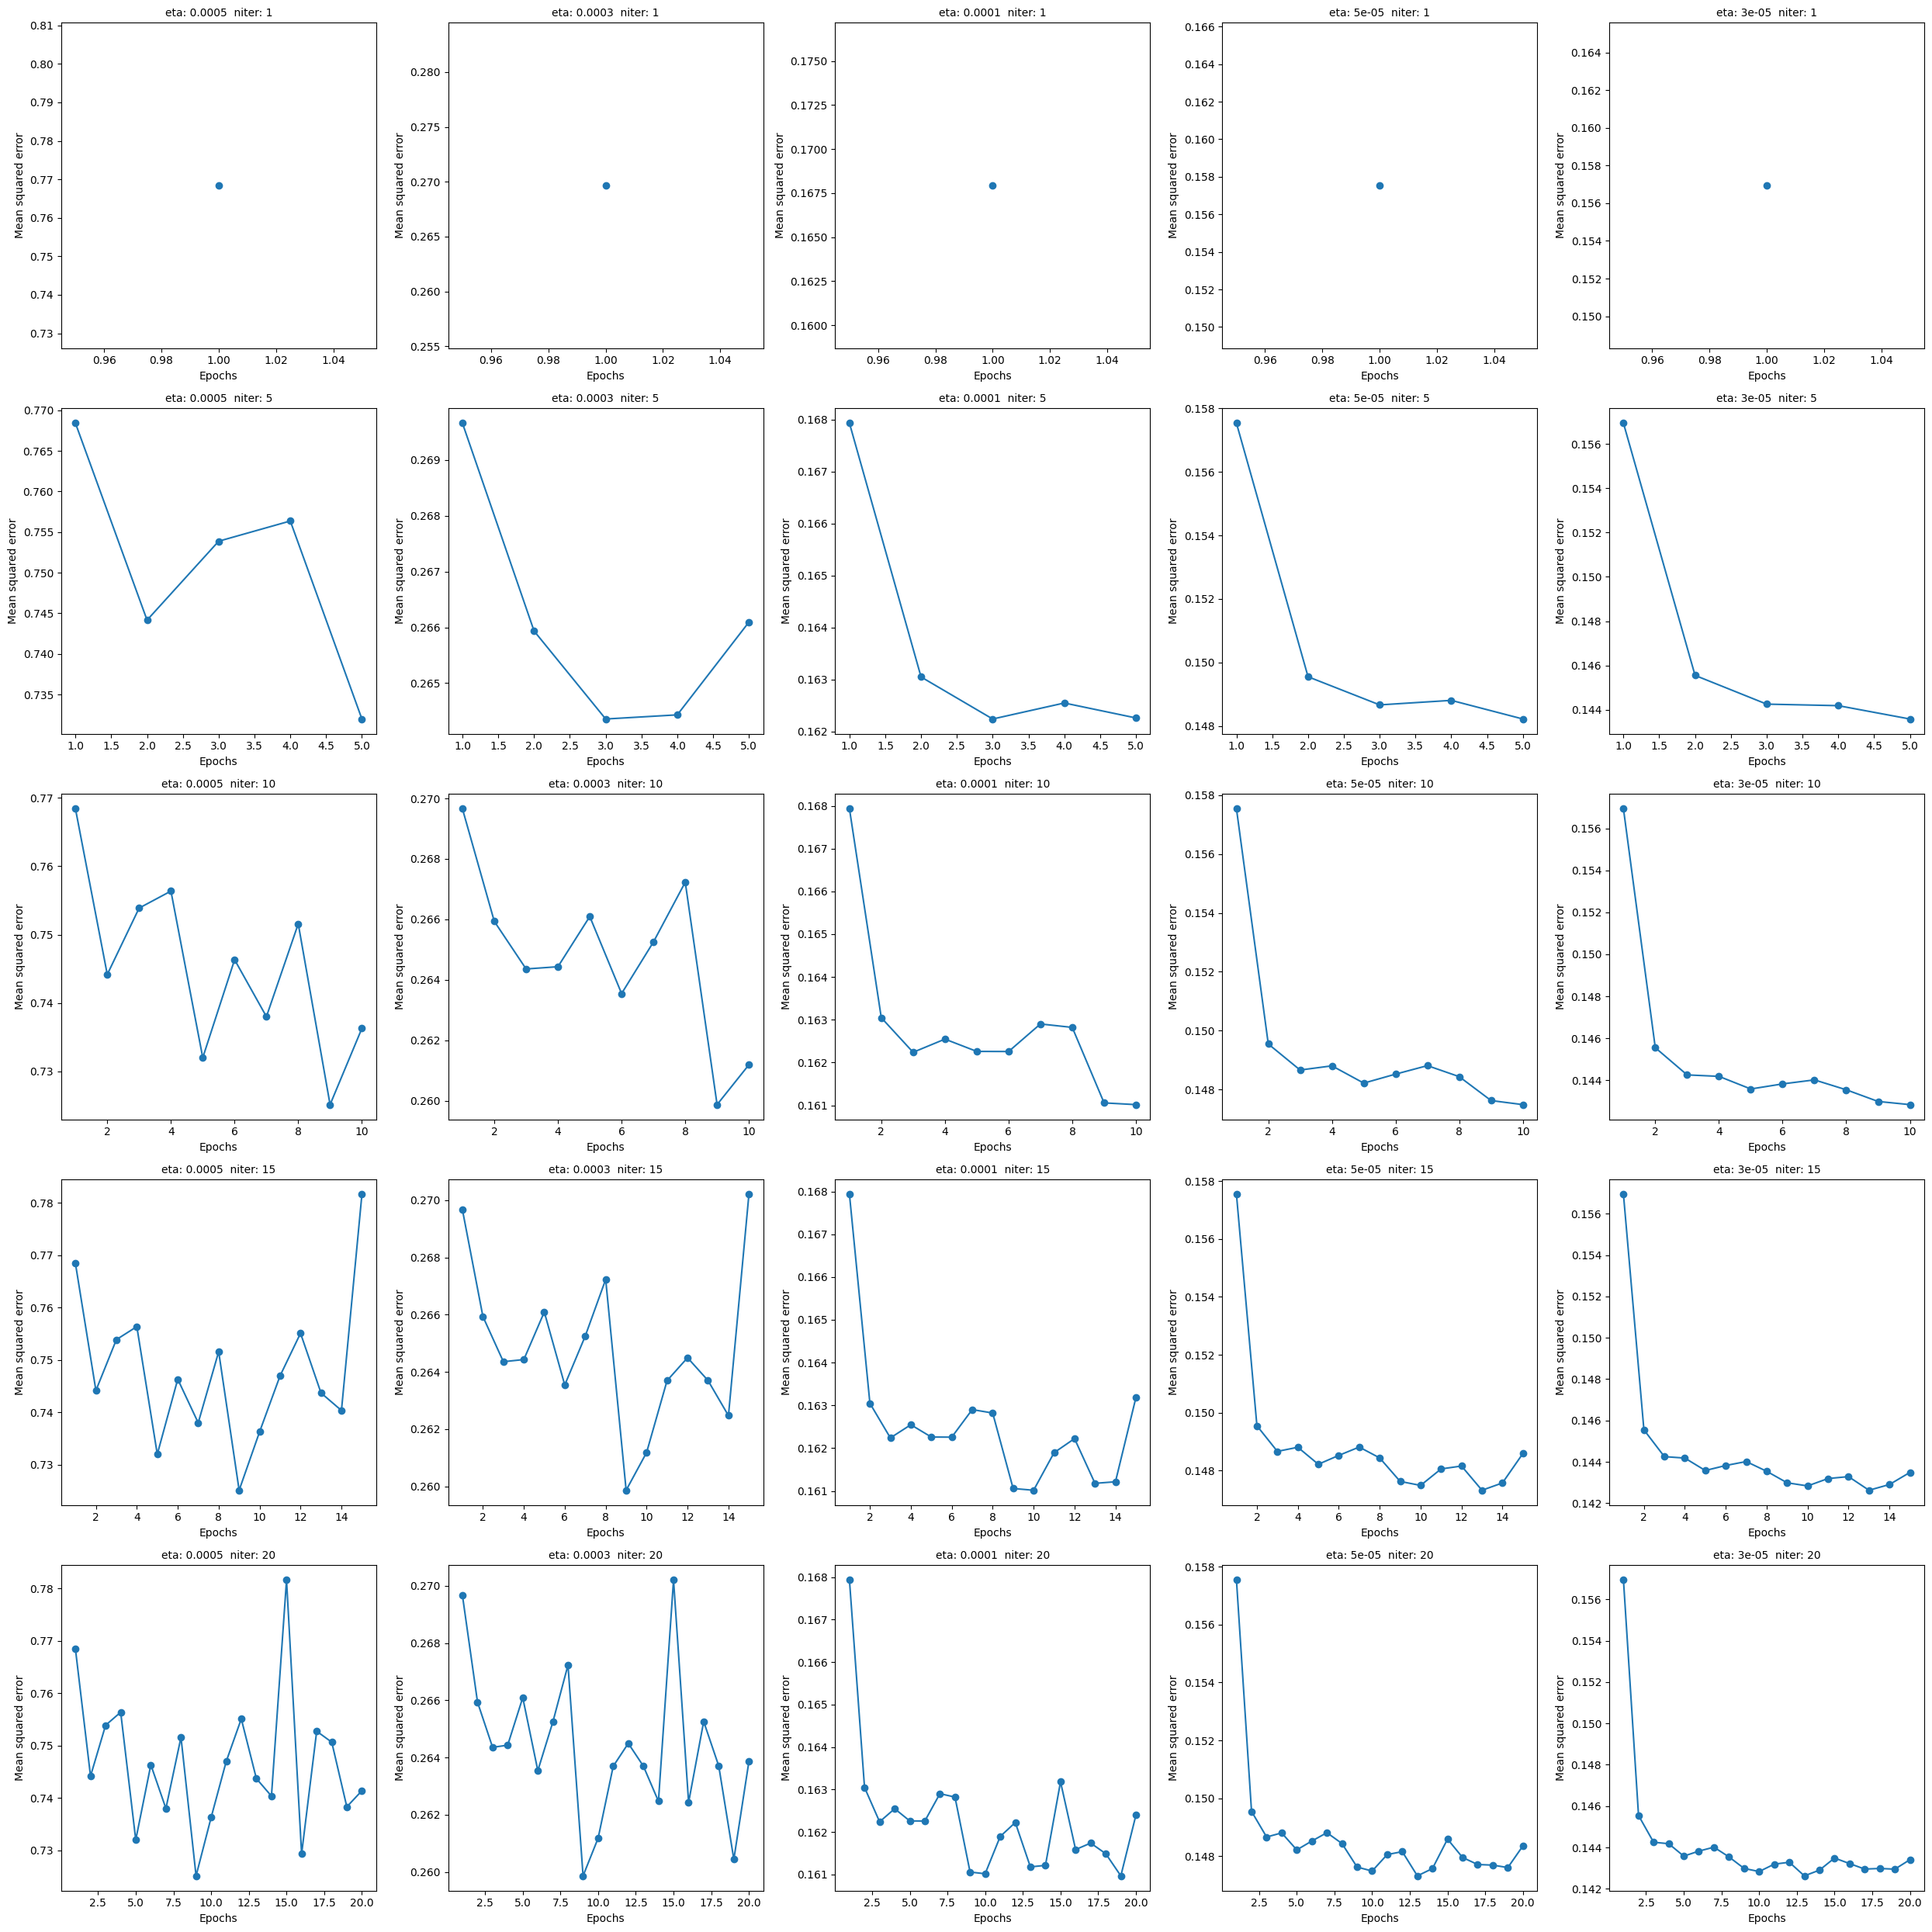


Highest accuracy: 0.8190 with eta 0.0001 and n_iter 10


In [39]:
# adaline sgd

# looking at parameters eta and n_iter
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))

list_eta = [0.0005, 0.0003, 0.0001, 0.00005, 0.00003]
list_niter = [1, 5, 10, 15, 20]

best_accuracy = 0
best_combo = (None, None)  # (eta, n_iter)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ada = AdalineSGD(n_iter=n_temp, eta=e_temp, shuffle=True, random_state=42).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Mean squared error', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        y_pred = ada.predict(X_test.loc[:,feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, y_pred)        
        print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {acc:.4f}")
        #print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

        if acc > best_accuracy:            
            best_accuracy = acc            
            best_combo = (e_temp, n_temp)
    
plt.tight_layout()
plt.show()

print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and n_iter {best_combo[1]}")

In [40]:
# Implement best verson of Adaline SGD on test dataset

ada_best = AdalineSGD(n_iter=10, eta=0.0001, shuffle=True, random_state=42).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_ada = ada_best.predict(X_df_test.loc[:,feature_cols].values)


df_ada_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'ada_pred': y_pred_best_ada
})


display(df_ada_pred.head())

#df_ada_pred.to_csv('adaline_predictions.csv', index=False)

,original_index,ada_pred
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


Perceptron accuracy with n_iter 1 and eta 0.0005: 0.7856
Perceptron accuracy with n_iter 1 and eta 0.0003: 0.8265
Perceptron accuracy with n_iter 1 and eta 0.0001: 0.7908
Perceptron accuracy with n_iter 1 and eta 5e-05: 0.7862
Perceptron accuracy with n_iter 1 and eta 3e-05: 0.8061
Perceptron accuracy with n_iter 5 and eta 0.0005: 0.8061
Perceptron accuracy with n_iter 5 and eta 0.0003: 0.7973
Perceptron accuracy with n_iter 5 and eta 0.0001: 0.7958
Perceptron accuracy with n_iter 5 and eta 5e-05: 0.8025
Perceptron accuracy with n_iter 5 and eta 3e-05: 0.7948
Perceptron accuracy with n_iter 10 and eta 0.0005: 0.8046
Perceptron accuracy with n_iter 10 and eta 0.0003: 0.8000
Perceptron accuracy with n_iter 10 and eta 0.0001: 0.8255
Perceptron accuracy with n_iter 10 and eta 5e-05: 0.8271
Perceptron accuracy with n_iter 10 and eta 3e-05: 0.8031
Perceptron accuracy with n_iter 15 and eta 0.0005: 0.7994
Perceptron accuracy with n_iter 15 and eta 0.0003: 0.8244
Perceptron accuracy with n_ite

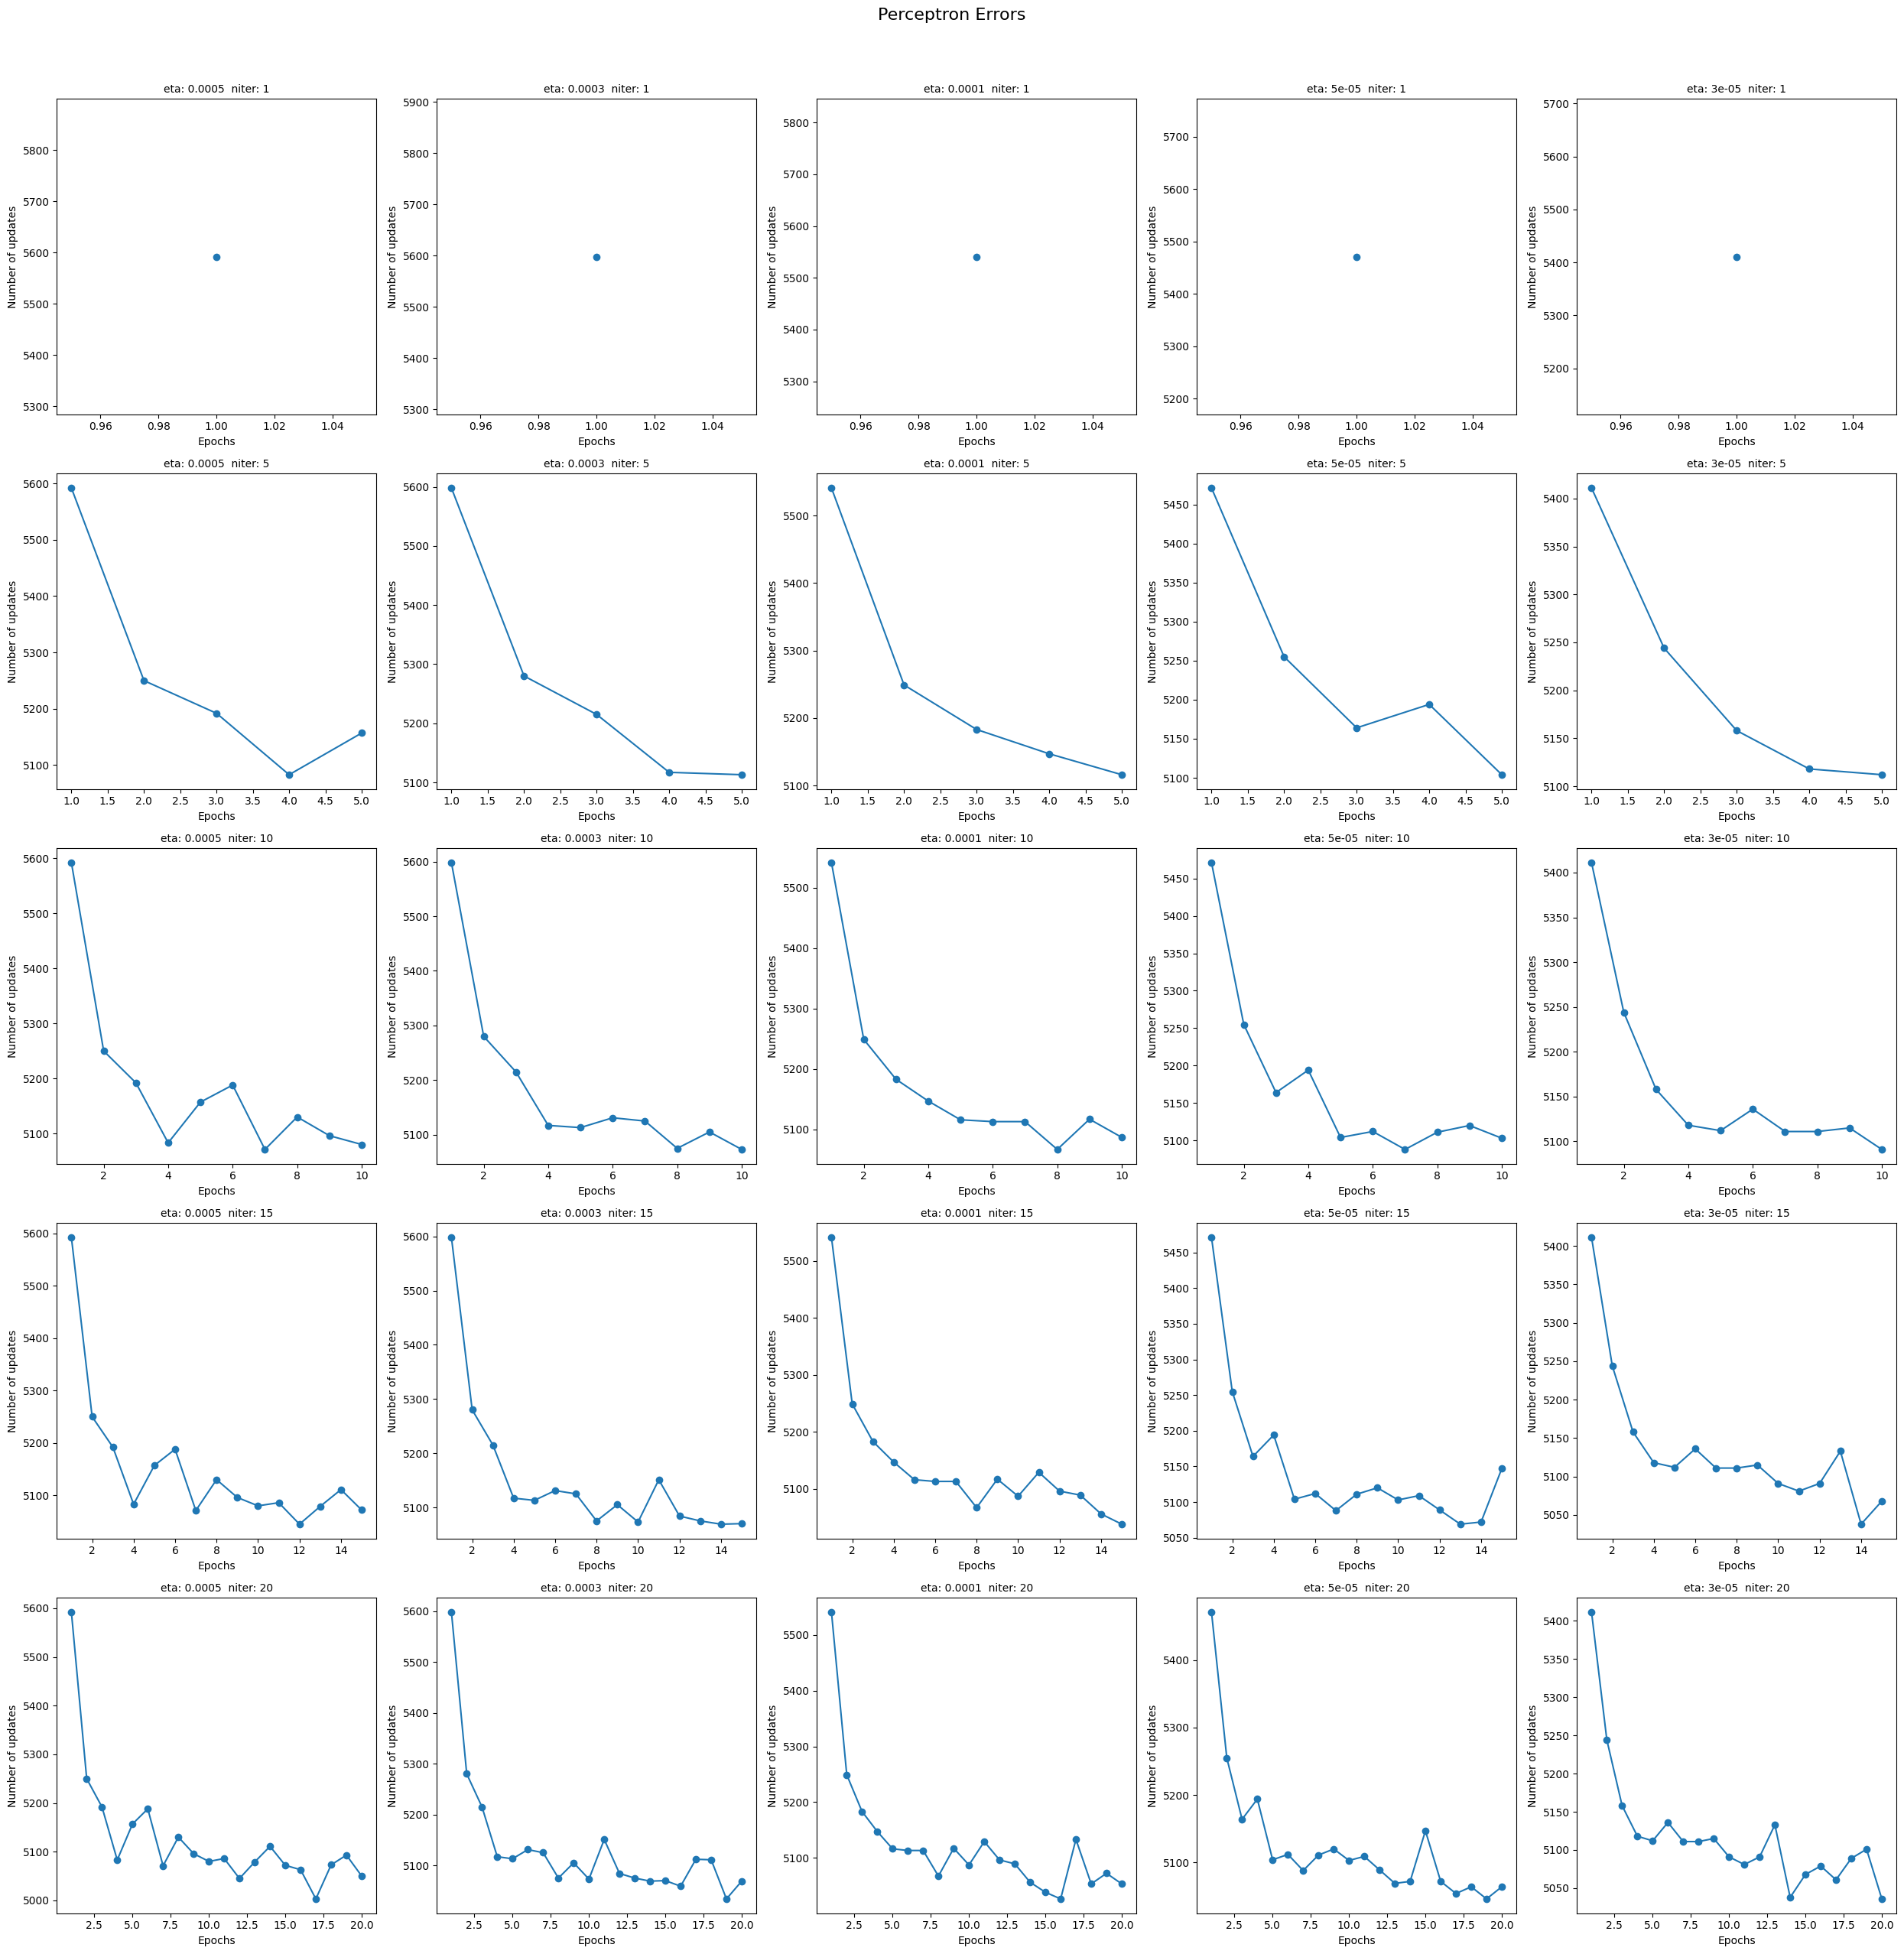


Highest accuracy: 0.8286 with eta 0.0001 and n_iter 15


In [41]:
# perceptron

list_eta = [0.0005, 0.0003, 0.0001, 0.00005, 0.00003]
list_niter = [1, 5, 10, 15, 20]

# Create a new figure for perceptron plots
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
fig.suptitle("Perceptron Errors", fontsize=16, y=1.02)

best_accuracy = 0
best_combo = (None, None)  # (eta, n_iter)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(n_iter=n_temp, eta=e_temp).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Number of updates', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)
        
        # Also calculate and print accuracy
        y_pred = ppn.predict(X_test.loc[:,feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, y_pred)      
        print(f"Perceptron accuracy with n_iter {n_temp} and eta {e_temp}: {acc:.4f}") 
        #print(f"Perceptron accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

        if acc > best_accuracy:            
            best_accuracy = acc            
            best_combo = (e_temp, n_temp)
    
plt.tight_layout()
plt.show()

print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and n_iter {best_combo[1]}")

In [42]:
# Implement best verson of Perceptron on test dataset

ppn_best = Perceptron(n_iter=15, eta=0.0001).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_ppn = ppn_best.predict(X_df_test.loc[:,feature_cols].values)


df_ppn_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'ppn_pred': y_pred_best_ppn
})


display(df_ppn_pred.head())

#df_ppn_pred.to_csv('perceptron_predictions.csv', index=False)

,original_index,ppn_pred
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [43]:

# provided adaline and perceptron

# Assumption:  This code assumes you have already clean, processed, and split a data set.
'''
Input Data Required:
X_train = cleaned, processed input data for training prediction models
y_train = response variable associated with X_train; truth values
X_test = cleaned, processed input data for testing prediction model created on training dataset
y_test = response variable associated with X_test; truth values

Note: Current order of rows ensure y_train = X_train and y_test = X_test, but if you sort and remove rows this association changes.
'''
# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.5, max_iter=20, random_state=42)
sk_ppn.fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
sk_y_pred_ppn = sk_ppn.predict(X_test.loc[:,feature_cols].values)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test.loc[:,'class'].values, sk_y_pred_ppn):.4f}")

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss='perceptron', eta0=0.001, learning_rate='constant', max_iter=12, random_state=42)
sk_ada.fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
sk_y_pred_ada = sk_ada.predict(X_test.loc[:,feature_cols].values)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test.loc[:,'class'].values, sk_y_pred_ada):.4f}")

Scikit-learn Perceptron accuracy: 0.8232
Scikit-learn Adaline (SGDClassifier) accuracy: 0.8155


In [44]:
# Sklearn perceptron loop 

list_eta = [0.5, 0.3, 0.1, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [10, 15, 20, 25, 30] # starting at 10 due to everything below 10 not reaching convergence

best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)
warned_max_iters = set()   # Track which max_iter values have triggered the warning

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        sk_ppn = SklearnPerceptron(eta0=e_temp, max_iter=n_temp, random_state=42)

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", category=ConvergenceWarning)

            sk_ppn = sk_ppn.fit(X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values)

            # Check for convergence warning and print only once per max_iter
            for warning in w:
                if issubclass(warning.category, ConvergenceWarning) and n_temp not in warned_max_iters:
                    print(f"⚠️ ConvergenceWarning: max_iter={n_temp} reached before convergence.")
                    warned_max_iters.add(n_temp)

        sk_y_pred_ppn = sk_ppn.predict(X_test.loc[:, feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, sk_y_pred_ppn)
        print(f"Scikit-learn Perceptron accuracy with max_iter {n_temp} and eta {e_temp}: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_combo = (e_temp, n_temp)
 
print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")


⚠️ ConvergenceWarning: max_iter=10 reached before convergence.
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.5: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.3: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.1: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.01: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.001: 0.8194
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.0001: 0.7873
Scikit-learn Perceptron accuracy with max_iter 10 and eta 1e-05: 0.7873
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.5: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.3: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.1: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.01: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.001: 0.8232
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.0001: 0.7873
Scikit-learn 

In [45]:
# Test Best Combo for Convergence - Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.01, max_iter=15, random_state=42)
sk_ppn.fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
sk_y_pred_ppn = sk_ppn.predict(X_test.loc[:,feature_cols].values)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test.loc[:,'class'].values, sk_y_pred_ppn):.4f}")

Scikit-learn Perceptron accuracy: 0.8232


In [46]:
# Implement best verson of Sklearn Perceptron on test dataset
# choosing eta = 0.01 since they all had same accuracy @ max_iter = 15 so this one is the moderate choice of learning rates

skppn_best = SklearnPerceptron(eta0=0.01, max_iter=15, random_state=42).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_skppn = skppn_best.predict(X_df_test.loc[:,feature_cols].values)


df_skppn_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'skppn_pred': y_pred_best_skppn
})


display(df_skppn_pred.head())

#df_skppn_pred.to_csv('sklearn_perceptron_predictions.csv', index=False)

,original_index,skppn_pred
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [47]:
# Sklearn perceptron loop using CV just to see what happens

list_eta = [0.5, 0.3, 0.1, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [10, 15, 20, 25, 30]

best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)
warned_max_iters = set()   # Track which max_iter values have triggered the warning

for n_temp in list_niter:
    for e_temp in list_eta:
        sk_ppn = SklearnPerceptron(eta0=e_temp, max_iter=n_temp, random_state=42)

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", category=ConvergenceWarning)

            scores = cross_val_score(sk_ppn, X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values, cv=5)
            mean_acc = scores.mean()

            # Check for convergence warning and print only once per max_iter
            for warning in w:
                if issubclass(warning.category, ConvergenceWarning) and n_temp not in warned_max_iters:
                    print(f"⚠️ ConvergenceWarning: max_iter={n_temp} reached before convergence.")
                    warned_max_iters.add(n_temp)

        print(f"CV mean accuracy with max_iter {n_temp} and eta {e_temp}: {mean_acc:.4f}")

        if mean_acc > best_accuracy:
            best_accuracy = mean_acc
            best_combo = (e_temp, n_temp)

print(f"\nBest CV mean accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")



⚠️ ConvergenceWarning: max_iter=10 reached before convergence.
CV mean accuracy with max_iter 10 and eta 0.5: 0.8008
CV mean accuracy with max_iter 10 and eta 0.3: 0.8008
CV mean accuracy with max_iter 10 and eta 0.1: 0.8012
CV mean accuracy with max_iter 10 and eta 0.01: 0.8012
CV mean accuracy with max_iter 10 and eta 0.001: 0.8012
CV mean accuracy with max_iter 10 and eta 0.0001: 0.7517
CV mean accuracy with max_iter 10 and eta 1e-05: 0.7517
⚠️ ConvergenceWarning: max_iter=15 reached before convergence.
CV mean accuracy with max_iter 15 and eta 0.5: 0.7990
CV mean accuracy with max_iter 15 and eta 0.3: 0.7990
CV mean accuracy with max_iter 15 and eta 0.1: 0.8012
CV mean accuracy with max_iter 15 and eta 0.01: 0.8012
CV mean accuracy with max_iter 15 and eta 0.001: 0.8012
CV mean accuracy with max_iter 15 and eta 0.0001: 0.7517
CV mean accuracy with max_iter 15 and eta 1e-05: 0.7517
⚠️ ConvergenceWarning: max_iter=20 reached before convergence.
CV mean accuracy with max_iter 20 and e

In [48]:
# Sklearn adaline loop 

list_eta = [0.3, 0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [12, 15, 20, 25, 30]

best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)
warned_max_iters = set()   # Track which max_iter values have triggered the warning

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        sk_ada = SGDClassifier(loss='perceptron', eta0=e_temp, learning_rate='constant', max_iter=n_temp, random_state=42)

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", category=ConvergenceWarning)

            sk_ada = sk_ada.fit(X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values)

            # Check for convergence warning and print only once per max_iter
            for warning in w:
                if issubclass(warning.category, ConvergenceWarning) and n_temp not in warned_max_iters:
                    print(f"⚠️ ConvergenceWarning: max_iter={n_temp} reached before convergence.")
                    warned_max_iters.add(n_temp)

        sk_y_pred_ada = sk_ada.predict(X_test.loc[:, feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, sk_y_pred_ada)
        print(f"Scikit-learn Adaline accuracy with max_iter {n_temp} and eta {e_temp}: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_combo = (e_temp, n_temp)
 
print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")


⚠️ ConvergenceWarning: max_iter=12 reached before convergence.
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.3: 0.7756
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.1: 0.8036
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.05: 0.7927
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.01: 0.7990
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.001: 0.8155
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.0001: 0.7869
Scikit-learn Adaline accuracy with max_iter 12 and eta 1e-05: 0.7900
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.3: 0.7829
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.1: 0.8036
⚠️ ConvergenceWarning: max_iter=15 reached before convergence.
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.05: 0.7883
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.01: 0.7990
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.001: 0.8155
Scikit-learn Adaline accuracy with max_iter 15 and eta 0.

In [49]:
# Test best combo for convergence - Sklearn Adaline
sk_ada = SGDClassifier(loss='perceptron', eta0=0.001, learning_rate='constant', max_iter=12, random_state=42)
sk_ada.fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
sk_y_pred_ada = sk_ada.predict(X_test.loc[:,feature_cols].values)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test.loc[:,'class'].values, sk_y_pred_ada):.4f}")

Scikit-learn Adaline (SGDClassifier) accuracy: 0.8155


In [50]:
# Implement best verson of Sklearn Adaline on test dataset

skada_best = SGDClassifier(loss='perceptron', eta0=0.001, learning_rate='constant', max_iter=12, random_state=42).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_skada = skada_best.predict(X_df_test.loc[:,feature_cols].values)


df_skada_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'skada_pred': y_pred_best_skada
})


display(df_skada_pred.head())

#df_skada_pred.to_csv('sklearn_adaline_predictions.csv', index=False)

,original_index,skada_pred
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [51]:
# Sklearn adaline loop using CV just to see what happens

list_eta = [0.3, 0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [12, 15, 20, 25, 30]

best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)
warned_max_iters = set()   # Track which max_iter values have triggered the warning

for n_temp in list_niter:
    for e_temp in list_eta:
        sk_ada = SGDClassifier(loss = 'perceptron', eta0=e_temp, max_iter=n_temp, random_state=42, learning_rate='constant')

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", category=ConvergenceWarning)

            scores = cross_val_score(sk_ada, X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values, cv=5)
            mean_acc = scores.mean()

            # Check for convergence warning and print only once per max_iter
            for warning in w:
                if issubclass(warning.category, ConvergenceWarning) and n_temp not in warned_max_iters:
                    print(f"⚠️ ConvergenceWarning: max_iter={n_temp} reached before convergence.")
                    warned_max_iters.add(n_temp)

        print(f"CV mean accuracy with max_iter {n_temp} and eta {e_temp}: {mean_acc:.4f}")

        if mean_acc > best_accuracy:
            best_accuracy = mean_acc
            best_combo = (e_temp, n_temp)

print(f"\nBest CV mean accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")

⚠️ ConvergenceWarning: max_iter=12 reached before convergence.
CV mean accuracy with max_iter 12 and eta 0.3: 0.7931
CV mean accuracy with max_iter 12 and eta 0.1: 0.7955
CV mean accuracy with max_iter 12 and eta 0.05: 0.7790
CV mean accuracy with max_iter 12 and eta 0.01: 0.7549
CV mean accuracy with max_iter 12 and eta 0.001: 0.7874
CV mean accuracy with max_iter 12 and eta 0.0001: 0.7754
CV mean accuracy with max_iter 12 and eta 1e-05: 0.7546
CV mean accuracy with max_iter 15 and eta 0.3: 0.7922
CV mean accuracy with max_iter 15 and eta 0.1: 0.8035
⚠️ ConvergenceWarning: max_iter=15 reached before convergence.
CV mean accuracy with max_iter 15 and eta 0.05: 0.7975
CV mean accuracy with max_iter 15 and eta 0.01: 0.7549
CV mean accuracy with max_iter 15 and eta 0.001: 0.7874
CV mean accuracy with max_iter 15 and eta 0.0001: 0.7754
CV mean accuracy with max_iter 15 and eta 1e-05: 0.7546
CV mean accuracy with max_iter 20 and eta 0.3: 0.7922
CV mean accuracy with max_iter 20 and eta 0.1: